# Analyzing Online Behavior for Public Health
### Project 1 - Joseph Okeno-Storms (djm7rd)

---
### Environment Setup

In [ ]:
# Install Packages
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install beautifulsoup4

In [ ]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from bs4 import BeautifulSoup
import datetime

---
### Oura Data Preparation


In [ ]:
# Load Oura CSV data
oura_data = pd.read_csv('oura_2024-12-22_2025-02-22_trends.csv')

In [ ]:
# Extract Key Features from data
oura_data = oura_data[[
    'date',
    'Deep Sleep Duration',
    'Total Sleep Duration',
    'REM Sleep Duration',
    'Restless Sleep',
    'Average Resting Heart Rate',
    'Sleep Latency',
    'Sleep Efficiency',
    'Bedtime Start',
    'Bedtime End',
]]

# Convert Timestamps to date format
oura_data['date'] = pd.to_datetime(oura_data['date'])
oura_data['Bedtime Start'] = pd.to_datetime(oura_data['Bedtime Start'])
oura_data['Bedtime End'] = pd.to_datetime(oura_data['Bedtime End'])

# Drop NA's
oura_data = oura_data.dropna()

# Create Derived Features
oura_data['Total Sleep Hours'] = oura_data['Total Sleep Duration'] / 60
oura_data['Deep Sleep Hours'] = oura_data['Deep Sleep Duration'] / 60
oura_data['REM Sleep Hours'] = oura_data['REM Sleep Duration'] / 60
oura_data['Bedtime Start Hour'] = oura_data['Bedtime Start'].dt.hour + oura_data['Bedtime Start'].dt.minute / 60
oura_data['Wakeup Hour'] = oura_data['Bedtime End'].dt.hour + oura_data['Bedtime End'].dt.minute / 60
oura_data['Sleep Latency Minutes'] = oura_data['Sleep Latency']

# Check data types and missing values
print(oura_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 0 to 52
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype                    
---  ------                      --------------  -----                    
 0   date                        53 non-null     datetime64[ns]           
 1   Deep Sleep Duration         53 non-null     float64                  
 2   Total Sleep Duration        53 non-null     float64                  
 3   REM Sleep Duration          53 non-null     float64                  
 4   Restless Sleep              53 non-null     float64                  
 5   Average Resting Heart Rate  53 non-null     float64                  
 6   Sleep Latency               53 non-null     float64                  
 7   Sleep Efficiency            53 non-null     float64                  
 8   Bedtime Start               53 non-null     datetime64[ns, UTC-05:00]
 9   Bedtime End                 53 non-null     datetime64[ns, UTC-05:00]
 1

### Oura Data Visualization

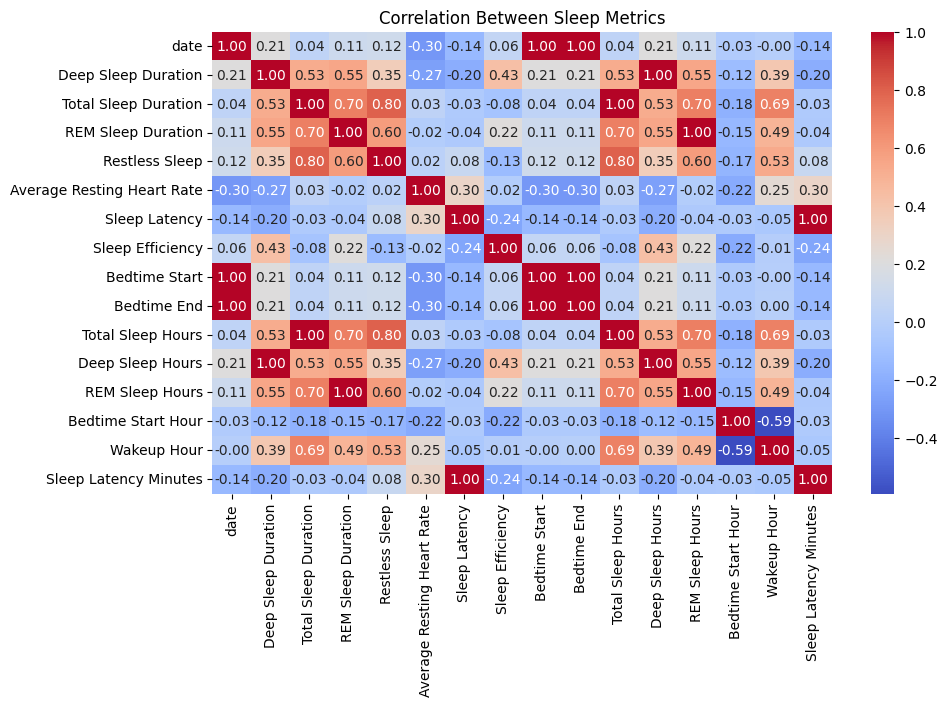

In [ ]:
# Plot Correlation matrix of sleep metrics
plt.figure(figsize=(10,6))
sns.heatmap(oura_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Sleep Metrics")
plt.show()

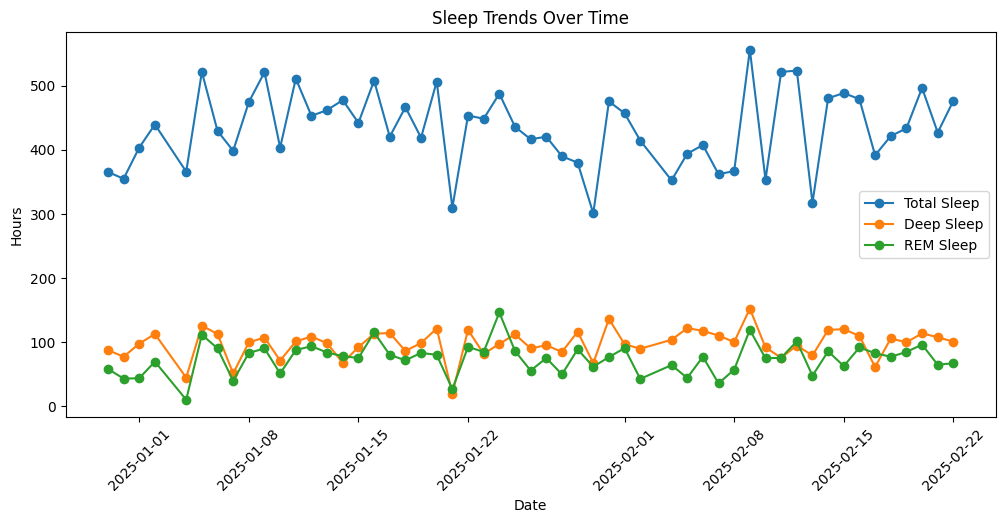

In [ ]:
# Plot Sleep Trends
plt.figure(figsize=(12,5))
plt.plot(oura_data['date'], oura_data['Total Sleep Hours'], marker='o', linestyle='-', label="Total Sleep")
plt.plot(oura_data['date'], oura_data['Deep Sleep Hours'], marker='o', linestyle='-', label="Deep Sleep")
plt.plot(oura_data['date'], oura_data['REM Sleep Hours'], marker='o', linestyle='-', label="REM Sleep")
plt.xlabel("Date")
plt.ylabel("Hours")
plt.legend()
plt.title("Sleep Trends Over Time")
plt.xticks(rotation=45)
plt.show()

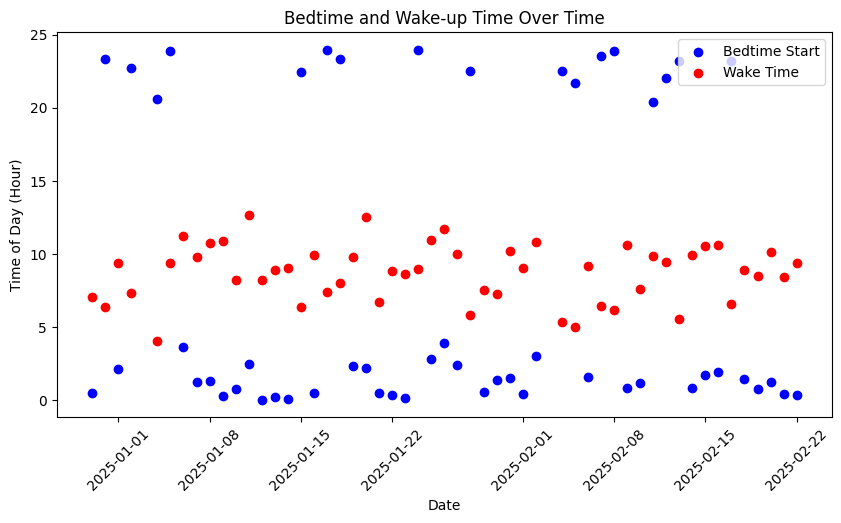

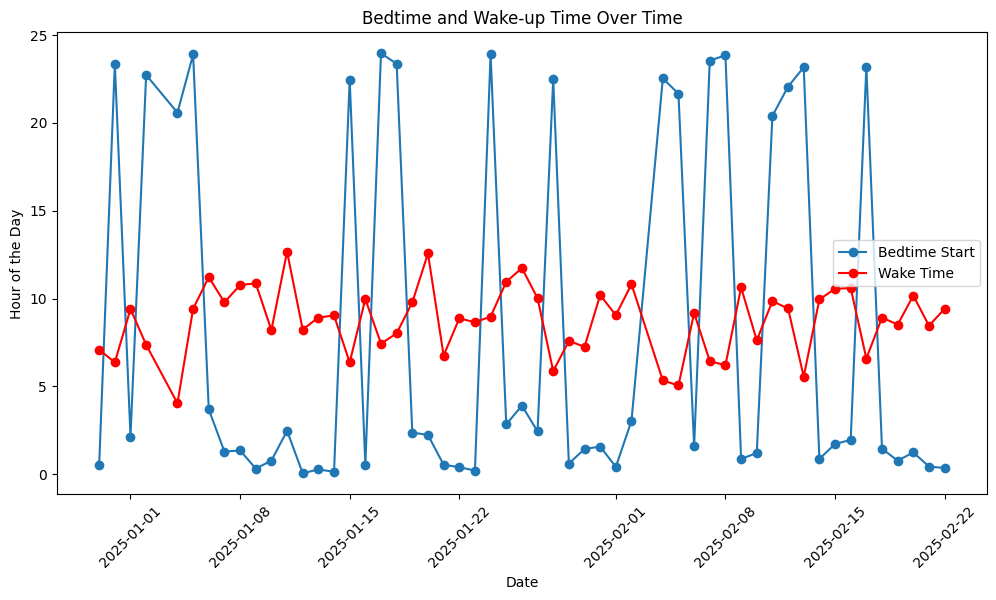

In [ ]:
# Plot Bedtime and Wake-up trends
plt.figure(figsize=(10,5))
plt.scatter(oura_data['date'], oura_data['Bedtime Start Hour'], label='Bedtime Start', color='blue')
plt.scatter(oura_data['date'], oura_data['Wakeup Hour'], label='Wake Time', color='red')
plt.xlabel("Date")
plt.ylabel("Time of Day (Hour)")
plt.legend()
plt.title("Bedtime and Wake-up Time Over Time")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(oura_data['date'], oura_data['Bedtime Start Hour'], marker='o', linestyle='-', label="Bedtime Start")
plt.plot(oura_data['date'], oura_data['Wakeup Hour'], marker='o', linestyle='-', label="Wake Time", color='red')
plt.xlabel("Date")
plt.ylabel("Hour of the Day")
plt.legend()
plt.title("Bedtime and Wake-up Time Over Time")
plt.xticks(rotation=45)
plt.show()

                  Sleep Efficiency  Deep Sleep Hours
Sleep Efficiency          1.000000          0.431472
Deep Sleep Hours          0.431472          1.000000


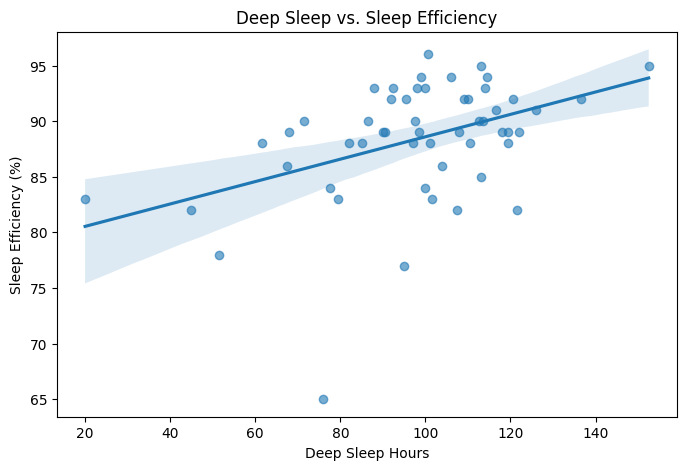

In [ ]:
# Compute correlation
correlation = oura_data[['Sleep Efficiency', 'Deep Sleep Hours']].corr()
print(correlation)

# Plot Deep Sleep and Sleep efficiency comparison
plt.figure(figsize=(8,5))
sns.regplot(x=oura_data['Deep Sleep Hours'], y=oura_data['Sleep Efficiency'], scatter_kws={'alpha':0.6})
plt.xlabel("Deep Sleep Hours")
plt.ylabel("Sleep Efficiency (%)")
plt.title("Deep Sleep vs. Sleep Efficiency")
plt.show()

Bedtime Variability (Std Dev): 10.06 hours
Wake-up Time Variability (Std Dev): 1.93 hours


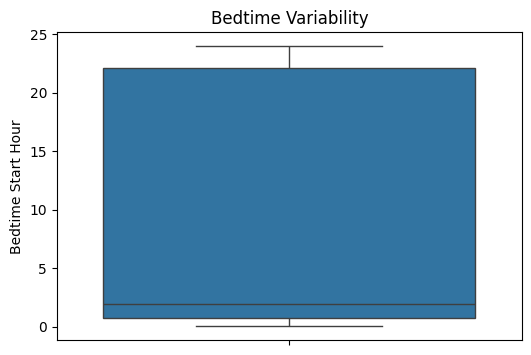

In [ ]:
# Calculate Bedtime Variability
bedtime_variability = np.std(oura_data['Bedtime Start Hour'])
wakeup_variability = np.std(oura_data['Wakeup Hour'])
print(f"Bedtime Variability (Std Dev): {bedtime_variability:.2f} hours")
print(f"Wake-up Time Variability (Std Dev): {wakeup_variability:.2f} hours")

# Plot Bedtime variability
plt.figure(figsize=(6,4))
sns.boxplot(y=oura_data['Bedtime Start Hour'])
plt.ylabel("Bedtime Start Hour")
plt.title("Bedtime Variability")
plt.show()

                       Sleep Latency Minutes  Total Sleep Hours
Sleep Latency Minutes                 1.0000            -0.0328
Total Sleep Hours                    -0.0328             1.0000


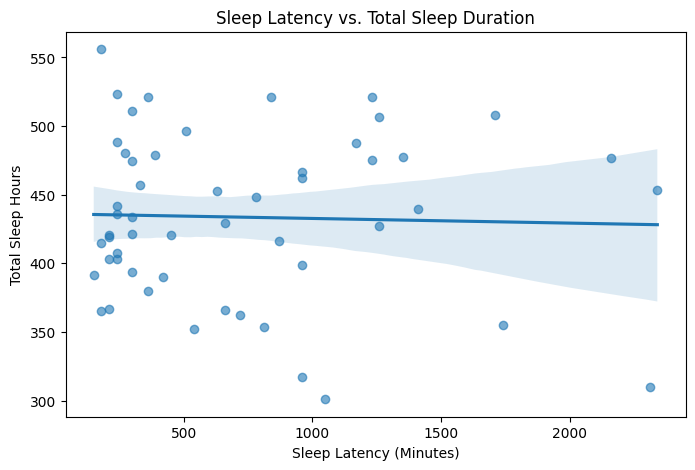

In [ ]:
# check if taking longer to fall asleep (high sleep latency) leads to shorter total sleep
correlation_latency_sleep = oura_data[['Sleep Latency Minutes', 'Total Sleep Hours']].corr()
print(correlation_latency_sleep)

# Plot sleep latency
plt.figure(figsize=(8,5))
sns.regplot(x=oura_data['Sleep Latency Minutes'], y=oura_data['Total Sleep Hours'], scatter_kws={'alpha':0.6})
plt.xlabel("Sleep Latency (Minutes)")
plt.ylabel("Total Sleep Hours")
plt.title("Sleep Latency vs. Total Sleep Duration")
plt.show()

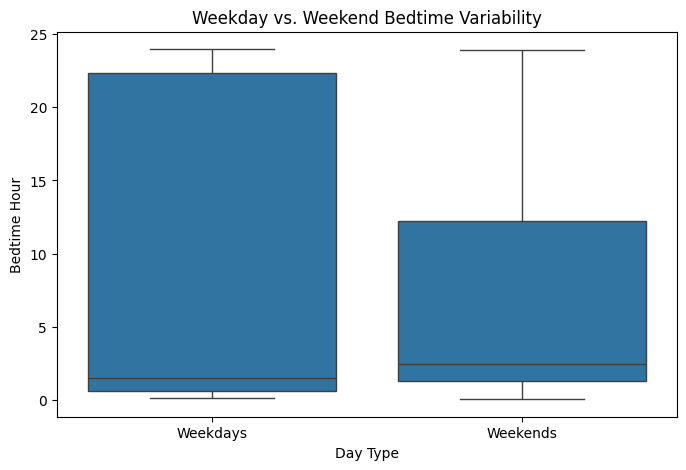

Weekday Bedtime Variability: 10.43 hours
Weekend Bedtime Variability: 9.75 hours


In [ ]:
# Convert date column to datetime if not already
oura_data['date'] = pd.to_datetime(oura_data['date'])

# Create a column for weekday (0 = Monday, 6 = Sunday)
oura_data['weekday'] = oura_data['date'].dt.weekday

# Create a weekend flag (1 = weekend, 0 = weekday)
oura_data['is_weekend'] = oura_data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Boxplots to Compare Bedtime on Weekdays vs. Weekends
plt.figure(figsize=(8,5))
sns.boxplot(x=oura_data['is_weekend'], y=oura_data['Bedtime Start Hour'])
plt.xticks([0,1], ["Weekdays", "Weekends"])
plt.xlabel("Day Type")
plt.ylabel("Bedtime Hour")
plt.title("Weekday vs. Weekend Bedtime Variability")
plt.show()

weekday_variability = oura_data[oura_data['is_weekend'] == 0]['Bedtime Start Hour'].std()
weekend_variability = oura_data[oura_data['is_weekend'] == 1]['Bedtime Start Hour'].std()

print(f"Weekday Bedtime Variability: {weekday_variability:.2f} hours")
print(f"Weekend Bedtime Variability: {weekend_variability:.2f} hours")

Low Sleep Efficiency Threshold: 86.00%
         date  Sleep Efficiency  Deep Sleep Hours  REM Sleep Hours  \
1  2024-12-31              84.0              77.5             43.5   
3  2025-01-02              85.0             113.0             70.0   
4  2025-01-04              82.0              45.0             10.5   
7  2025-01-07              78.0              51.5             40.0   
8  2025-01-08              84.0             100.0             83.5   
9  2025-01-09              82.0             107.5             90.5   
11 2025-01-11              83.0             101.5             88.0   
20 2025-01-20              82.0             121.5             80.5   
21 2025-01-21              83.0              20.0             27.0   
30 2025-01-30              86.0              67.5             62.0   
34 2025-02-04              86.0             104.0             64.5   
41 2025-02-11              65.0              76.0             76.0   
42 2025-02-12              77.0              95.0  

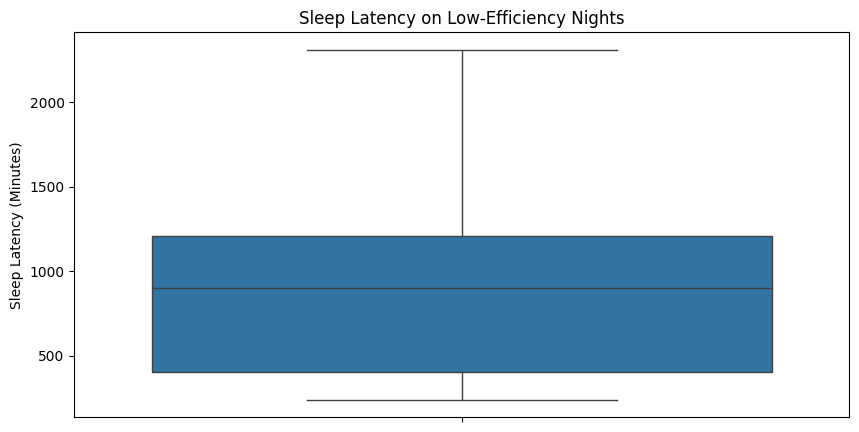

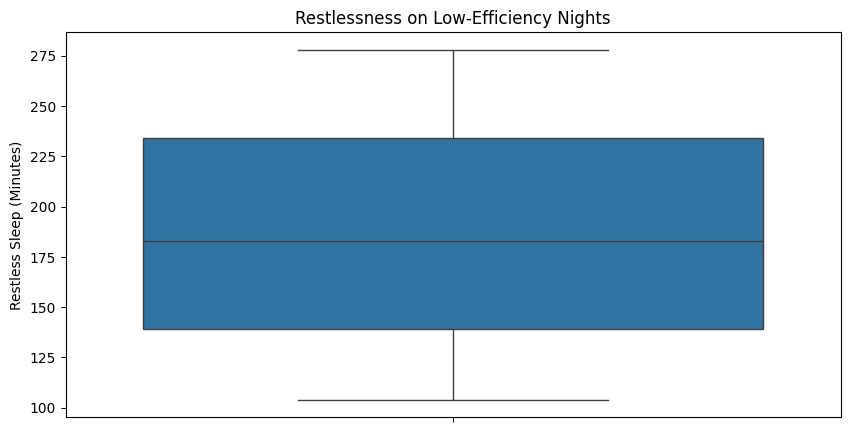

In [ ]:
# Compare Sleep Latency and Nights with Low Efficiency
low_efficiency_threshold = oura_data['Sleep Efficiency'].quantile(0.25)
low_efficiency_nights = oura_data[oura_data['Sleep Efficiency'] <= low_efficiency_threshold]
print(f"Low Sleep Efficiency Threshold: {low_efficiency_threshold:.2f}%")
print(low_efficiency_nights[['date', 'Sleep Efficiency', 'Deep Sleep Hours', 'REM Sleep Hours', 'Sleep Latency Minutes', 'Restless Sleep']])

plt.figure(figsize=(10,5))
sns.boxplot(y=low_efficiency_nights['Sleep Latency Minutes'])
plt.ylabel("Sleep Latency (Minutes)")
plt.title("Sleep Latency on Low-Efficiency Nights")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(y=low_efficiency_nights['Restless Sleep'])
plt.ylabel("Restless Sleep (Minutes)")
plt.title("Restlessness on Low-Efficiency Nights")
plt.show()

---
### Google Takeout Data Preparation

In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

# Define the root directory where your data is stored
root_dir = "/content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout"

# Find all HTML files in subdirectories
html_files = glob.glob(os.path.join(root_dir, '**', '*.html'), recursive=True)

# Check the number of files found
print(f"Found {len(html_files)} HTML files.")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Found 25 HTML files.
Processing file: /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Travel/MyActivity.html...
Processing file: /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Gmail/MyActivity.html...
Processing file: /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Drive/MyActivity.html...
Processing file: /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Developers/MyActivity.html...
Processing file: /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Help/MyActivity.html...
Processing file: /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Act

In [ ]:
# Extract activity data from an HTML file
def extract_google_activity(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")

    activities = []

    # Find all content cells containing activity
    for content_cell in soup.find_all("div", class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1"):
        text = content_cell.get_text(separator=" ").strip()

        # Split based on the timestamp format
        parts = text.rsplit(" ", 5)  # Split last 5 words (to separate date/time from activity)

        if len(parts) < 6:
            continue  # Skip if the structure is incorrect

        activity = " ".join(parts[:-5])  # Everything before the last 5 words is the activity
        timestamp = " ".join(parts[-5:])  # The last 5 words form the timestamp
        activities.append((activity, timestamp))

    return activities

# Extract activity data from all HTML files
all_activities = []
for file in html_files:
    print(f"Processing {file}...")
    all_activities.extend(extract_google_activity(file))
    print(f"Length of All Activities: {len(all_activities)}")

# Convert to DataFrame
google_activity_df = pd.DataFrame(all_activities, columns=["Activity", "Timestamp"])
print(f"Length of Google Activity DataFrame: {len(google_activity_df)}")

# Convert timestamp to datetime format
google_activity_df["Timestamp"] = pd.to_datetime(google_activity_df["Timestamp"], errors="coerce")

# Split date and time
google_activity_df["Date"] = google_activity_df["Timestamp"].dt.date
google_activity_df["Time"] = google_activity_df["Timestamp"].dt.time

# Drop rows where conversion failed
google_activity_df.dropna(inplace=True)

# Display the first few rows
print(google_activity_df.head())

Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Travel/MyActivity.html...
Length of All Activities: 2
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Gmail/MyActivity.html...
Length of All Activities: 293
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Drive/MyActivity.html...
Length of All Activities: 302
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Developers/MyActivity.html...
Length of All Activities: 313
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Help/MyActivity.html...
Length of All Activities: 394
Processing /content/drive/My Drive/Colab Notebooks/S25 - Online Behavior Public Health/GoogleTakeout/My Activity 1/Image Search/MyActivity.html...


Streaming output truncated to the last 5000 lines.
<ipython-input-27-4b8d02b08eb1>:37: FutureWarning: Parsed string "Feb 28, 2017, 8:22:46 PM EST" included an un-recognized timezone "EST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  google_activity_df["Timestamp"] = pd.to_datetime(google_activity_df["Timestamp"], errors="coerce")
<ipython-input-27-4b8d02b08eb1>:37: FutureWarning: Parsed string "Feb 28, 2017, 8:22:37 PM EST" included an un-recognized timezone "EST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  google_activity_df["Timestamp"] = pd.to_datetime(google_activity_df["Timestamp"], errors="coerce")
<ipython-input-27-4b8d02b08eb1>:37: FutureWarning: Parsed string "Feb 28, 2017, 10:13:50 AM E

                                            Activity           Timestamp  \
0                                        Used Travel 2022-12-18 17:12:40   
1               Tracked flight prices BWI to DEN,ORD 2020-01-27 16:52:46   
2  Visited  https://mail.google.com/mail/?extsrc=... 2025-02-18 11:09:48   
3                                  Searched for  sun 2025-02-18 11:09:45   
4                                         Used Gmail 2025-02-15 16:23:02   

         Date      Time  
0  2022-12-18  17:12:40  
1  2020-01-27  16:52:46  
2  2025-02-18  11:09:48  
3  2025-02-18  11:09:45  
4  2025-02-15  16:23:02  


<ipython-input-27-4b8d02b08eb1>:37: FutureWarning: Parsed string "Jul 15, 2015, 8:56:22 PM EST" included an un-recognized timezone "EST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  google_activity_df["Timestamp"] = pd.to_datetime(google_activity_df["Timestamp"], errors="coerce")
<ipython-input-27-4b8d02b08eb1>:37: FutureWarning: Parsed string "Jul 15, 2015, 8:29:58 PM EST" included an un-recognized timezone "EST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  google_activity_df["Timestamp"] = pd.to_datetime(google_activity_df["Timestamp"], errors="coerce")
<ipython-input-27-4b8d02b08eb1>:37: FutureWarning: Parsed string "Jul 15, 2015, 4:54:01 PM EST" included an un-recognized timezone "EST". Droppi

In [ ]:
# Save google data to csv
google_activity_df.to_csv('google_activity_df.csv', index=False)

# Define start and end date
start_date = pd.Timestamp("2024-12-22")
end_date = pd.Timestamp("2025-02-22")

# Convert the 'Date' column to datetime if not already
google_activity_df["Date"] = pd.to_datetime(google_activity_df["Date"])

# Filter the DataFrame for the specified date range
filtered_google_activity = google_activity_df[(google_activity_df["Date"] >= start_date) & (google_activity_df["Date"] <= end_date)]

# Display the first few rows to verify
print(filtered_google_activity.head())

# Save filtered google data to csv
filtered_google_activity.to_csv('filtered_google_activity.csv', index=False)

                                            Activity           Timestamp  \
2  Visited  https://mail.google.com/mail/?extsrc=... 2025-02-18 11:09:48   
3                                  Searched for  sun 2025-02-18 11:09:45   
4                                         Used Gmail 2025-02-15 16:23:02   
5                                         Used Gmail 2025-02-15 16:22:47   
6                                Searched for  lasik 2025-02-15 16:22:40   

        Date      Time  
2 2025-02-18  11:09:48  
3 2025-02-18  11:09:45  
4 2025-02-15  16:23:02  
5 2025-02-15  16:22:47  
6 2025-02-15  16:22:40  


In [ ]:
# Read filtered google activity from csv file
filtered_google_activity = pd.read_csv('filtered_google_activity.csv')

# Preprocess columns
filtered_google_activity['Timestamp'] = pd.to_datetime(filtered_google_activity['Timestamp'])
filtered_google_activity['Date'] = pd.to_datetime(filtered_google_activity['Date'])
filtered_google_activity['Time'] = pd.to_datetime(filtered_google_activity['Time'])
filtered_google_activity['Activity'] = filtered_google_activity['Activity'].astype(str)

# Drop NA's
filtered_google_activity = filtered_google_activity.dropna()

print(filtered_google_activity.info())

<ipython-input-10-37c92be385f0>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_google_activity['Time'] = pd.to_datetime(filtered_google_activity['Time'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8411 entries, 0 to 8410
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Activity   8411 non-null   object        
 1   Timestamp  8411 non-null   datetime64[ns]
 2   Date       8411 non-null   datetime64[ns]
 3   Time       8411 non-null   datetime64[ns]
dtypes: datetime64[ns](3), object(1)
memory usage: 263.0+ KB
None


In [ ]:
# Get estimated Bedtime Start (latest activity before sleep)
bedtime_df = filtered_google_activity.groupby("Date")["Timestamp"].max().reset_index()
bedtime_df.rename(columns={"Timestamp": "Bedtime Start"}, inplace=True)

# Get estimated Bedtime End (earliest activity on the next calendar day)
wake_df = filtered_google_activity.copy()
wake_df["Next Date"] = wake_df["Date"] - pd.Timedelta(days=1)  # Shift dates back to align with sleep start
wake_df = wake_df.groupby("Next Date")["Timestamp"].min().reset_index()
wake_df.rename(columns={"Timestamp": "Bedtime End", "Next Date": "Date"}, inplace=True)

# Merge Bedtime Start and Bedtime End on Date
google_sleep_df = bedtime_df.merge(wake_df, on="Date", how="inner")

# Calculate Total Sleep Hours
google_sleep_df["Total Sleep Hours"] = (google_sleep_df["Bedtime End"] - google_sleep_df["Bedtime Start"]).dt.total_seconds() / 3600

# Calculate Sleep Latency (time between bedtime and first inactivity)
google_sleep_df["Sleep Latency Minutes"] = (google_sleep_df["Bedtime Start"] - google_sleep_df["Date"]).dt.total_seconds() / 60

# Create more derived features
google_sleep_df['Bedtime Start Hour'] = google_sleep_df['Bedtime Start'].dt.hour + google_sleep_df['Bedtime Start'].dt.minute / 60
google_sleep_df['Wakeup Hour'] = google_sleep_df['Bedtime End'].dt.hour + google_sleep_df['Bedtime End'].dt.minute / 60

# Assume an ideal sleep is 8 hours
ideal_sleep_minutes = 8 * 60  # 8 hours in minutes

# Calculate Sleep Efficiency based on total sleep duration
google_sleep_df["Sleep Efficiency"] = (google_sleep_df["Total Sleep Hours"] * 60) / ideal_sleep_minutes * 100

print(google_sleep_df.head())

        Date       Bedtime Start         Bedtime End  Total Sleep Hours  \
0 2024-12-22 2024-12-22 23:40:46 2024-12-23 00:17:26           0.611111   
1 2024-12-23 2024-12-23 23:17:50 2024-12-24 01:10:08           1.871667   
2 2024-12-24 2024-12-24 23:05:56 2024-12-25 15:37:24          16.524444   
3 2024-12-25 2024-12-25 23:48:44 2024-12-26 00:15:39           0.448611   
4 2024-12-26 2024-12-26 23:21:28 2024-12-27 00:09:26           0.799444   

   Sleep Latency Minutes  Bedtime Start Hour  Wakeup Hour  Sleep Efficiency  
0            1420.766667           23.666667     0.283333          7.638889  
1            1397.833333           23.283333     1.166667         23.395833  
2            1385.933333           23.083333    15.616667        206.555556  
3            1428.733333           23.800000     0.250000          5.607639  
4            1401.466667           23.350000     0.150000          9.993056  


### Google Takeout Data Analysis

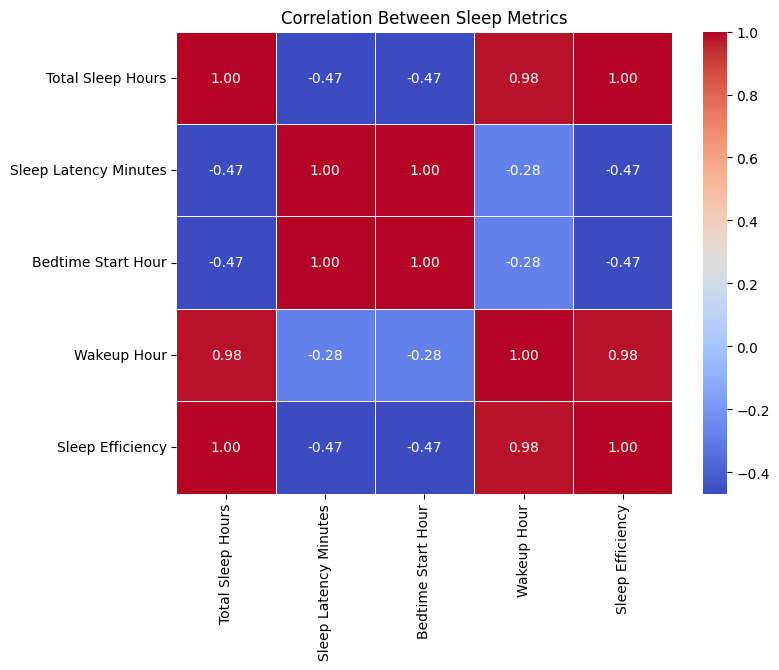

In [ ]:
# Correlation between sleep metrics
correlation_columns = ["Total Sleep Hours", "Sleep Latency Minutes", "Bedtime Start Hour", "Wakeup Hour", "Sleep Efficiency"]
corr_matrix = google_sleep_df[correlation_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Sleep Metrics")
plt.show()

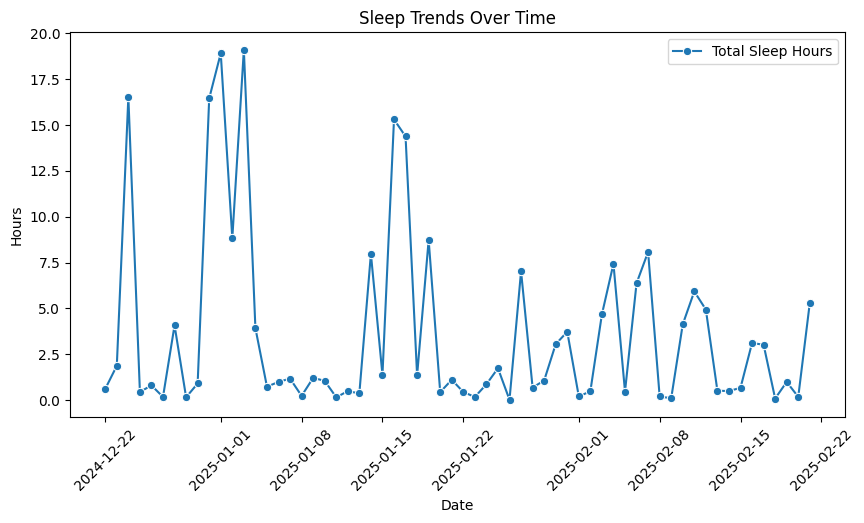

In [ ]:
# Sleep Trends over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=google_sleep_df, x="Date", y="Total Sleep Hours", marker="o", label="Total Sleep Hours")

plt.xlabel("Date")
plt.ylabel("Hours")
plt.title("Sleep Trends Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

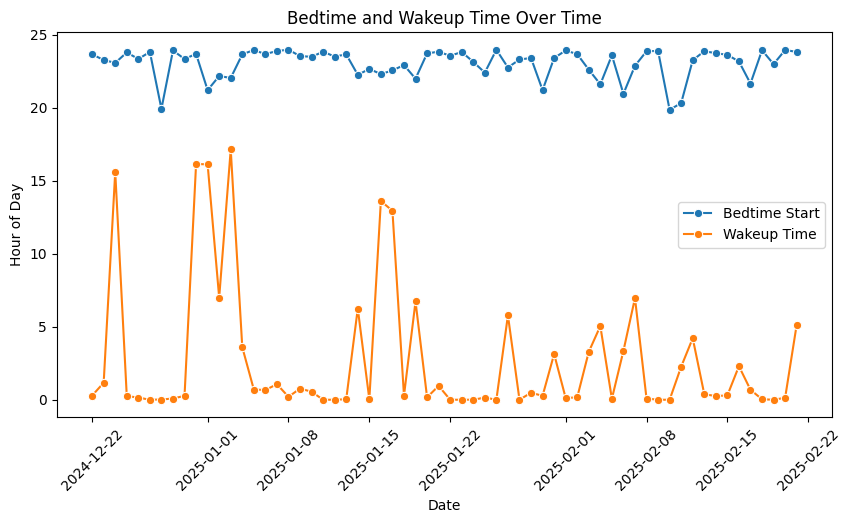

In [ ]:
# Bedtime and Wakeup Time over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=google_sleep_df, x="Date", y="Bedtime Start Hour", marker="o", label="Bedtime Start")
sns.lineplot(data=google_sleep_df, x="Date", y="Wakeup Hour", marker="o", label="Wakeup Time")

plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.title("Bedtime and Wakeup Time Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

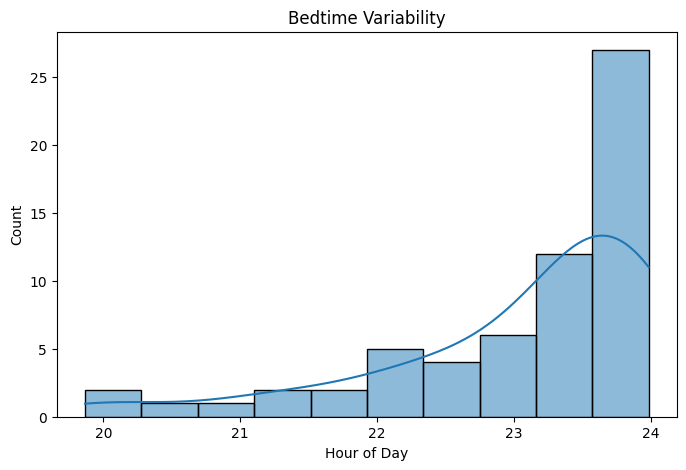

In [ ]:
# Bedtime variability
plt.figure(figsize=(8, 5))
sns.histplot(google_sleep_df["Bedtime Start Hour"], bins=10, kde=True)

plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.title("Bedtime Variability")
plt.show()

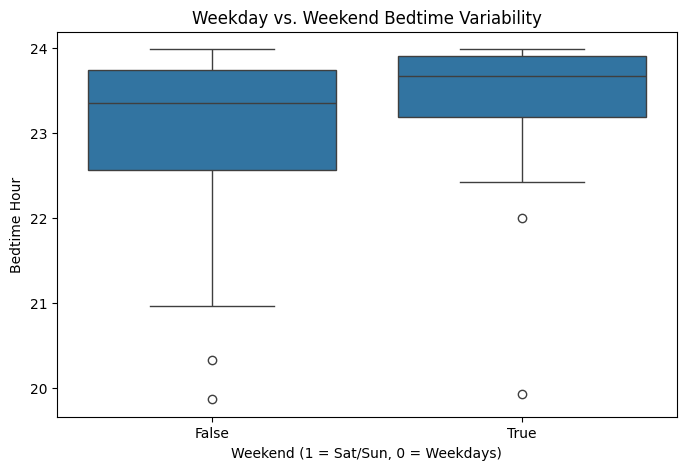

In [ ]:
# Weekday vs Weekend Bedtime Variability
google_sleep_df["Weekday"] = google_sleep_df["Date"].dt.weekday  # Monday = 0, Sunday = 6
google_sleep_df["Weekend"] = google_sleep_df["Weekday"] >= 5  # Saturday & Sunday are weekends

plt.figure(figsize=(8, 5))
sns.boxplot(data=google_sleep_df, x="Weekend", y="Bedtime Start Hour")

plt.xlabel("Weekend (1 = Sat/Sun, 0 = Weekdays)")
plt.ylabel("Bedtime Hour")
plt.title("Weekday vs. Weekend Bedtime Variability")
plt.show()

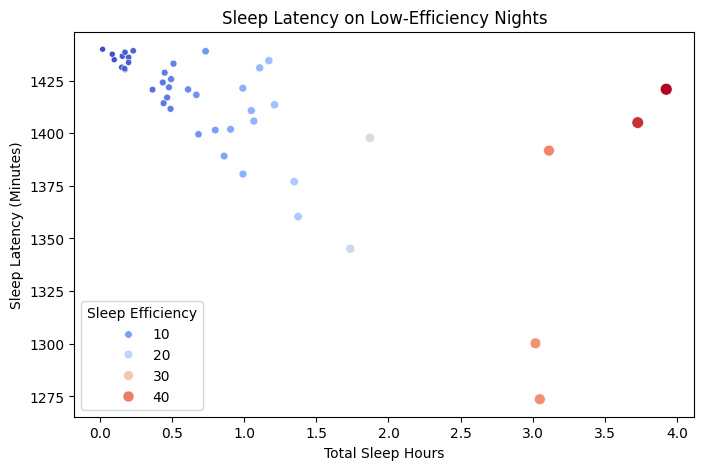

In [ ]:
# Sleep Latency on Low-Efficiency nights
low_efficiency_df = google_sleep_df[google_sleep_df["Sleep Efficiency"] < 50]
plt.figure(figsize=(8, 5))
sns.scatterplot(data=low_efficiency_df, x="Total Sleep Hours", y="Sleep Latency Minutes", hue="Sleep Efficiency", size="Sleep Efficiency", palette="coolwarm")

plt.xlabel("Total Sleep Hours")
plt.ylabel("Sleep Latency (Minutes)")
plt.title("Sleep Latency on Low-Efficiency Nights")
plt.show()